# Customer Churn Prediction Analysis

## Objective
This analysis aims to predict customer churn probability using multiple machine learning methods and compare their performance. Understanding customer churn is crucial for businesses to identify at-risk customers and implement retention strategies.

## Dataset Overview
The dataset contains customer information including demographics, account details, and churn status. We will explore the data, build predictive models, and evaluate which method performs best for churn prediction.

## Methodology
We will use three different machine learning approaches:
1. **Logistic Regression** - A linear model that provides interpretable results
2. **Random Forest** - An ensemble tree-based method that captures non-linear relationships
3. **XGBoost** - A gradient boosting method known for high performance

Each model will be evaluated using multiple metrics including accuracy, precision, recall, F1-score, and ROC-AUC to ensure comprehensive comparison.


In [3]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, roc_curve, confusion_matrix,
                             classification_report)
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Download latest version
path = kagglehub.dataset_download("shrutimechlearn/churn-modelling")
print("Path to dataset files:", path)

Path to dataset files: /home/vscode/.cache/kagglehub/datasets/shrutimechlearn/churn-modelling/versions/1


## 1. Data Loading and Initial Exploration

First, we load the dataset and examine its basic structure, including data types, missing values, and summary statistics. This helps us understand the data quality and identify any preprocessing needs.


In [4]:
# Load the dataset
df = pd.read_csv(f"{path}/Churn_Modelling.csv")

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe())


Dataset Shape: (10000, 14)

First few rows:
   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1 

## 2. Exploratory Data Analysis (EDA)

Understanding the distribution of our target variable (churn) and exploring relationships between features and churn is essential. This analysis helps identify:
- Class imbalance in the target variable
- Demographic patterns in churn behavior
- Feature distributions that might impact model performance

### Key Observations:
- The dataset contains 10,000 customer records
- Churn rate is approximately 20%, indicating class imbalance
- Features include customer demographics, account details, and engagement metrics


Target Variable Distribution:
Exited
0    7963
1    2037
Name: count, dtype: int64

Churn Rate: 20.37%


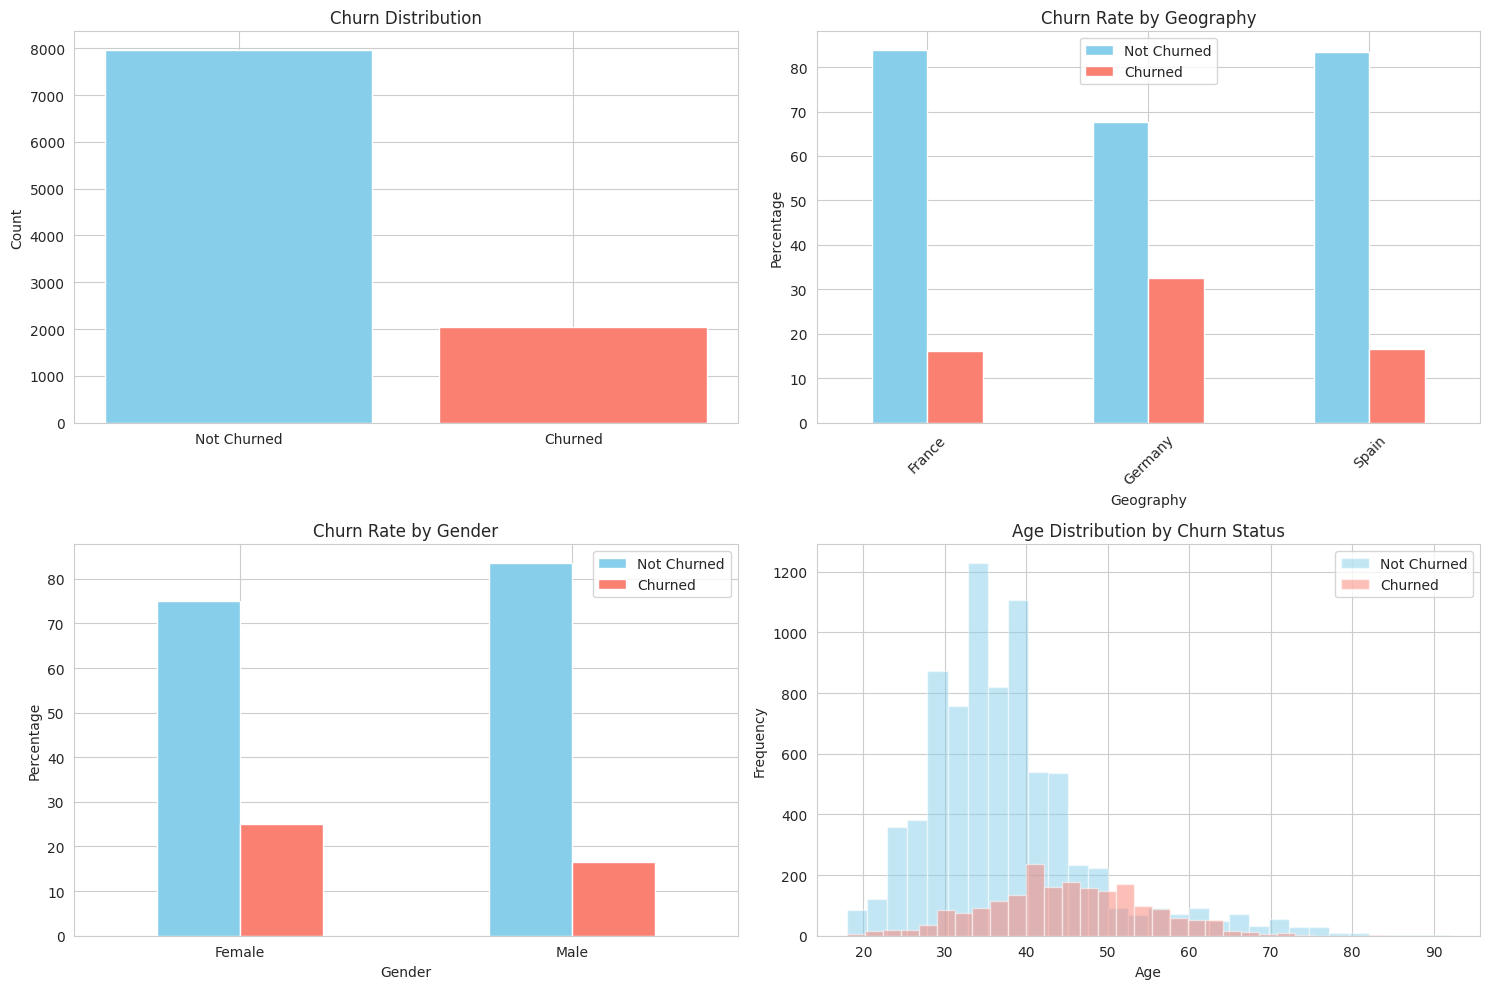

In [5]:
# Exploratory Data Analysis
print("Target Variable Distribution:")
print(df['Exited'].value_counts())
print(f"\nChurn Rate: {df['Exited'].mean():.2%}")

# Visualize target distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Target distribution
axes[0, 0].bar(['Not Churned', 'Churned'], df['Exited'].value_counts().sort_index(), 
               color=['skyblue', 'salmon'])
axes[0, 0].set_title('Churn Distribution')
axes[0, 0].set_ylabel('Count')

# Churn by Geography
churn_geo = pd.crosstab(df['Geography'], df['Exited'], normalize='index') * 100
churn_geo.plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'salmon'])
axes[0, 1].set_title('Churn Rate by Geography')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].legend(['Not Churned', 'Churned'])
axes[0, 1].tick_params(axis='x', rotation=45)

# Churn by Gender
churn_gender = pd.crosstab(df['Gender'], df['Exited'], normalize='index') * 100
churn_gender.plot(kind='bar', ax=axes[1, 0], color=['skyblue', 'salmon'])
axes[1, 0].set_title('Churn Rate by Gender')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].legend(['Not Churned', 'Churned'])
axes[1, 0].tick_params(axis='x', rotation=0)

# Age distribution by churn
df[df['Exited']==0]['Age'].hist(alpha=0.5, label='Not Churned', ax=axes[1, 1], bins=30, color='skyblue')
df[df['Exited']==1]['Age'].hist(alpha=0.5, label='Churned', ax=axes[1, 1], bins=30, color='salmon')
axes[1, 1].set_title('Age Distribution by Churn Status')
axes[1, 1].set_xlabel('Age')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 3. Correlation Analysis

Examining correlations between features helps identify:
- Multicollinearity issues that might affect model performance
- Features that are strongly related to churn
- Redundant information that could be removed

Strong correlations with the target variable (Exited) indicate important predictors of churn.


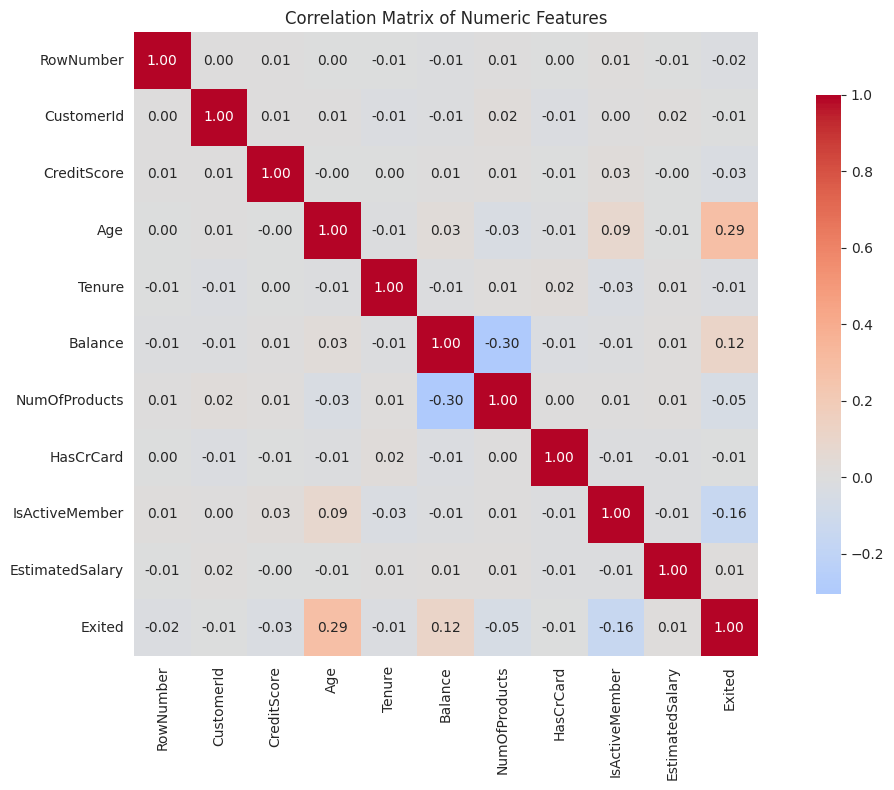


Correlation with Exited (Target Variable):
Exited             1.000000
Age                0.285323
Balance            0.118533
EstimatedSalary    0.012097
CustomerId        -0.006248
HasCrCard         -0.007138
Tenure            -0.014001
RowNumber         -0.016571
CreditScore       -0.027094
NumOfProducts     -0.047820
IsActiveMember    -0.156128
Name: Exited, dtype: float64


In [6]:
# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

print("\nCorrelation with Exited (Target Variable):")
corr_with_target = df[numeric_cols].corr()['Exited'].sort_values(ascending=False)
print(corr_with_target)


## 4. Data Preprocessing

Before training models, we need to:
- Remove irrelevant identifiers (RowNumber, CustomerId, Surname)
- Encode categorical variables (Geography, Gender) into numerical format
- Split data into training and testing sets (80/20 split)
- Scale features for algorithms that require it (Logistic Regression)

We use stratified splitting to maintain the same churn rate in both training and test sets, ensuring fair evaluation.


In [7]:
# Data Preprocessing
# Drop unnecessary columns
df_processed = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Separate features and target
X = df_processed.drop('Exited', axis=1)
y = df_processed['Exited']

# Encode categorical variables
le_geography = LabelEncoder()
le_gender = LabelEncoder()

X['Geography'] = le_geography.fit_transform(X['Geography'])
X['Gender'] = le_gender.fit_transform(X['Gender'])

print("Feature columns after encoding:", X.columns.tolist())
print("\nGeography encoding:", dict(zip(le_geography.classes_, le_geography.transform(le_geography.classes_))))
print("Gender encoding:", dict(zip(le_gender.classes_, le_gender.transform(le_gender.classes_))))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set churn rate: {y_train.mean():.2%}")
print(f"Test set churn rate: {y_test.mean():.2%}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Feature columns after encoding: ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

Geography encoding: {'France': np.int64(0), 'Germany': np.int64(1), 'Spain': np.int64(2)}
Gender encoding: {'Female': np.int64(0), 'Male': np.int64(1)}

Training set size: 8000
Test set size: 2000
Training set churn rate: 20.38%
Test set churn rate: 20.35%


## 5. Model Training and Evaluation

### Method 1: Logistic Regression

Logistic Regression is a linear model that estimates the probability of churn. It's:
- **Interpretable**: Coefficients show the impact of each feature
- **Fast**: Quick to train and make predictions
- **Baseline**: Good starting point for comparison

We use balanced class weights to handle the class imbalance (20% churn rate).


In [8]:
# Method 1: Logistic Regression
print("=" * 60)
print("METHOD 1: LOGISTIC REGRESSION")
print("=" * 60)

lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, y_pred_proba_lr)

print(f"Accuracy: {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"ROC-AUC: {lr_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Cross-validation
cv_scores_lr = cross_val_score(lr_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-Validation ROC-AUC (mean ± std): {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}")


METHOD 1: LOGISTIC REGRESSION
Accuracy: 0.7075
Precision: 0.3832
Recall: 0.7174
F1-Score: 0.4996
ROC-AUC: 0.7741

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.38      0.72      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.73      2000


Cross-Validation ROC-AUC (mean ± std): 0.7549 ± 0.0131


### Method 2: Random Forest

Random Forest is an ensemble method that builds multiple decision trees and combines their predictions. It:
- **Handles non-linearity**: Captures complex relationships between features
- **Provides feature importance**: Identifies which features most influence churn
- **Reduces overfitting**: By averaging multiple trees

We use balanced class weights and tune hyperparameters (max_depth, min_samples_split) to optimize performance.


In [9]:
# Method 2: Random Forest
print("=" * 60)
print("METHOD 2: RANDOM FOREST")
print("=" * 60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"ROC-AUC: {rf_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance_rf.head())

# Cross-validation
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-Validation ROC-AUC (mean ± std): {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")


METHOD 2: RANDOM FOREST
Accuracy: 0.8365
Precision: 0.5873
Recall: 0.6609
F1-Score: 0.6220
ROC-AUC: 0.8578

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1593
           1       0.59      0.66      0.62       407

    accuracy                           0.84      2000
   macro avg       0.75      0.77      0.76      2000
weighted avg       0.84      0.84      0.84      2000


Top 5 Most Important Features:
           feature  importance
3              Age    0.324322
6    NumOfProducts    0.212585
5          Balance    0.115997
9  EstimatedSalary    0.084063
0      CreditScore    0.082996

Cross-Validation ROC-AUC (mean ± std): 0.8597 ± 0.0086


### Method 3: XGBoost (Gradient Boosting)

XGBoost is an advanced gradient boosting algorithm that:
- **Sequentially improves**: Each tree corrects errors from previous trees
- **High performance**: Often achieves best results on tabular data
- **Handles imbalance**: Uses scale_pos_weight to balance classes

We configure XGBoost with regularization parameters to prevent overfitting and improve generalization.


In [10]:
# Method 3: XGBoost (Gradient Boosting)
print("=" * 60)
print("METHOD 3: XGBOOST (GRADIENT BOOSTING)")
print("=" * 60)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # Handle class imbalance
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Metrics
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_precision = precision_score(y_test, y_pred_xgb)
xgb_recall = recall_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-Score: {xgb_f1:.4f}")
print(f"ROC-AUC: {xgb_roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance_xgb.head())

# Cross-validation
cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"\nCross-Validation ROC-AUC (mean ± std): {cv_scores_xgb.mean():.4f} ± {cv_scores_xgb.std():.4f}")


METHOD 3: XGBOOST (GRADIENT BOOSTING)
Accuracy: 0.8070
Precision: 0.5181
Recall: 0.7371
F1-Score: 0.6085
ROC-AUC: 0.8605

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      1593
           1       0.52      0.74      0.61       407

    accuracy                           0.81      2000
   macro avg       0.72      0.78      0.74      2000
weighted avg       0.84      0.81      0.82      2000


Top 5 Most Important Features:
          feature  importance
6   NumOfProducts    0.282957
3             Age    0.170405
8  IsActiveMember    0.166758
1       Geography    0.084441
5         Balance    0.073548

Cross-Validation ROC-AUC (mean ± std): 0.8611 ± 0.0128


## 6. Model Comparison

Now we compare all three models across multiple evaluation metrics:

- **Accuracy**: Overall correctness of predictions
- **Precision**: Of predicted churns, how many actually churned (reduces false positives)
- **Recall**: Of actual churns, how many were correctly identified (reduces false negatives)
- **F1-Score**: Harmonic mean of precision and recall (balanced metric)
- **ROC-AUC**: Ability to distinguish between churned and non-churned customers

The ROC curve shows the trade-off between true positive rate and false positive rate at different classification thresholds.


MODEL COMPARISON

Performance Metrics Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression    0.7075     0.3832  0.7174    0.4996   0.7741
1        Random Forest    0.8365     0.5873  0.6609    0.6220   0.8578
2              XGBoost    0.8070     0.5181  0.7371    0.6085   0.8605


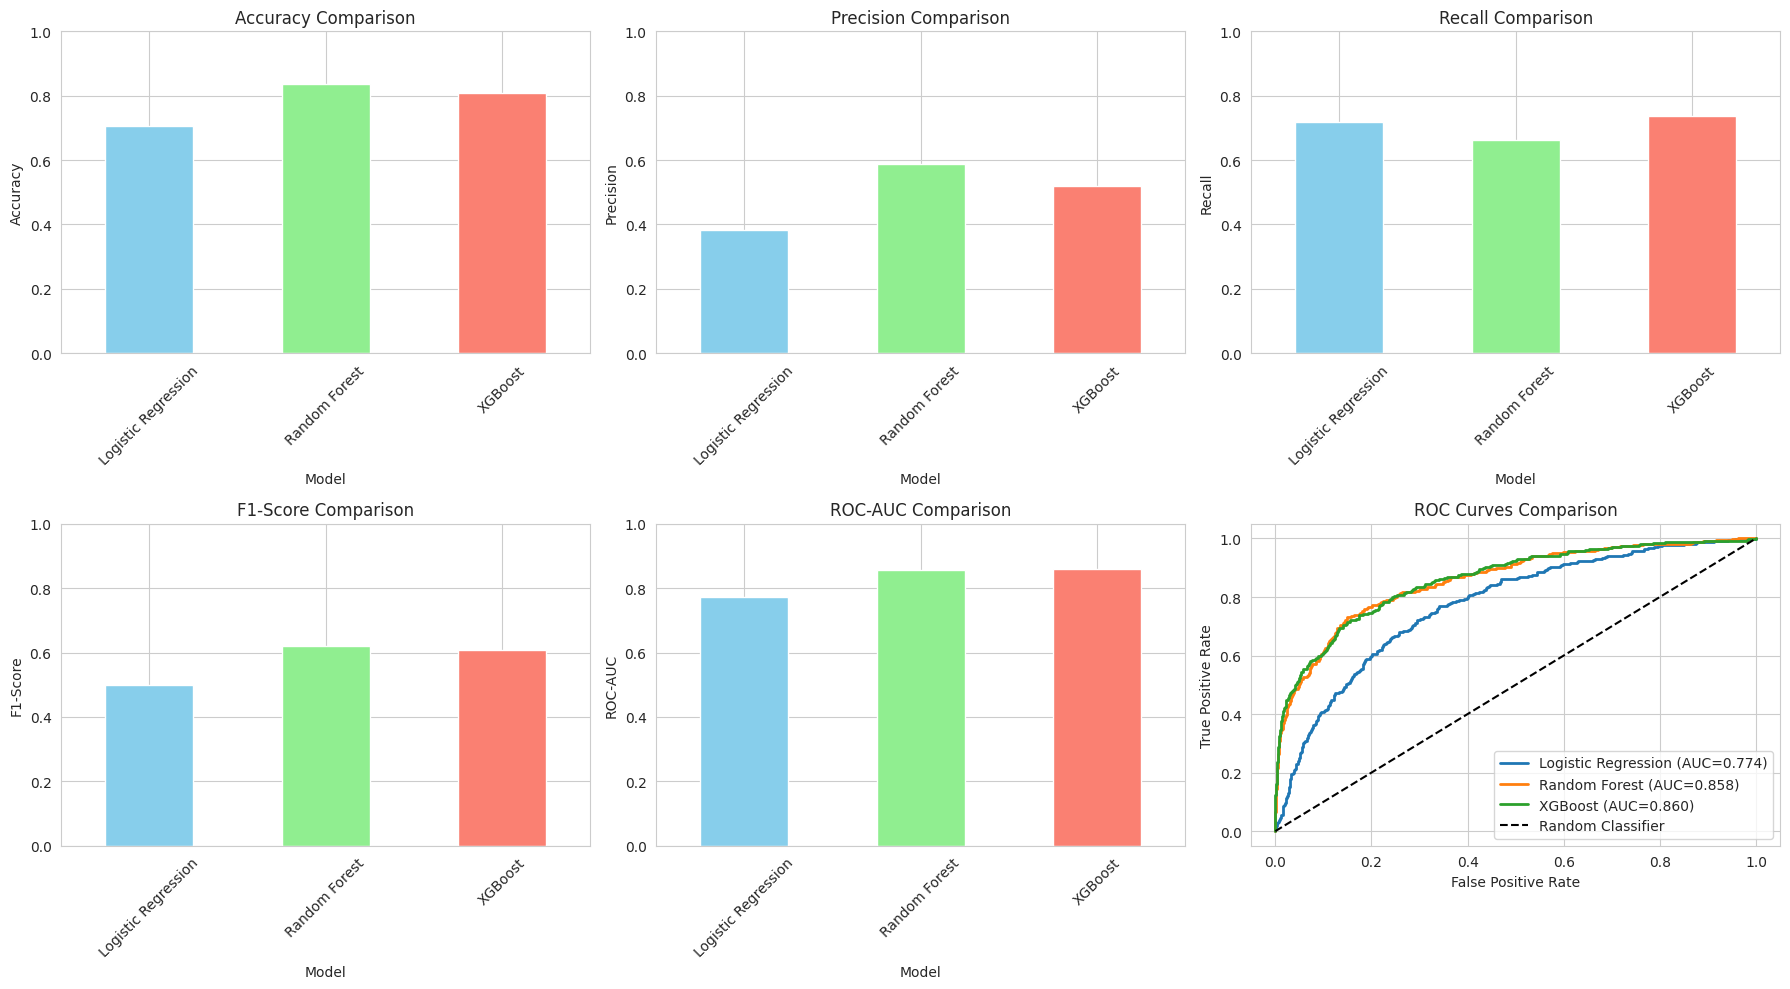

In [11]:
# Model Comparison
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy],
    'Precision': [lr_precision, rf_precision, xgb_precision],
    'Recall': [lr_recall, rf_recall, xgb_recall],
    'F1-Score': [lr_f1, rf_f1, xgb_f1],
    'ROC-AUC': [lr_roc_auc, rf_roc_auc, xgb_roc_auc]
})

print("\nPerformance Metrics Comparison:")
print(comparison_df.round(4))

# Visualize comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    comparison_df.plot(x='Model', y=metric, kind='bar', ax=axes[row, col], 
                       color=['skyblue', 'lightgreen', 'salmon'], legend=False)
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)
    axes[row, col].set_ylim([0, 1])

# ROC Curves
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

axes[1, 2].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={lr_roc_auc:.3f})', linewidth=2)
axes[1, 2].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_roc_auc:.3f})', linewidth=2)
axes[1, 2].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_roc_auc:.3f})', linewidth=2)
axes[1, 2].plot([0, 1], [0, 1], 'k--', label='Random Classifier')
axes[1, 2].set_xlabel('False Positive Rate')
axes[1, 2].set_ylabel('True Positive Rate')
axes[1, 2].set_title('ROC Curves Comparison')
axes[1, 2].legend()
axes[1, 2].grid(True)

plt.tight_layout()
plt.show()


### Confusion Matrices

Confusion matrices provide detailed insight into model performance:
- **True Negatives (TN)**: Correctly predicted non-churned customers
- **False Positives (FP)**: Incorrectly predicted as churned (Type I error)
- **False Negatives (FN)**: Missed churned customers (Type II error)
- **True Positives (TP)**: Correctly predicted churned customers

For churn prediction, minimizing False Negatives is often critical - we don't want to miss customers who will actually churn.


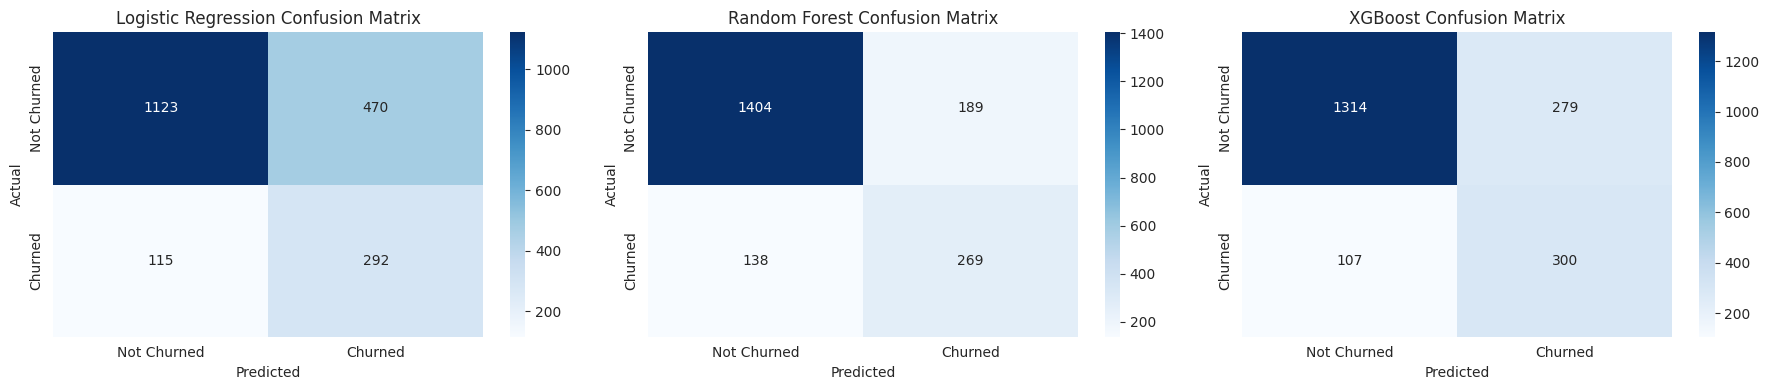

In [12]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

models = [
    ('Logistic Regression', y_pred_lr, y_test),
    ('Random Forest', y_pred_rf, y_test),
    ('XGBoost', y_pred_xgb, y_test)
]

for idx, (name, y_pred, y_true) in enumerate(models):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['Not Churned', 'Churned'],
                yticklabels=['Not Churned', 'Churned'])
    axes[idx].set_title(f'{name} Confusion Matrix')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


### Feature Importance Analysis

Understanding which features drive churn predictions helps:
- **Business insights**: Identify key factors causing customer churn
- **Model interpretation**: Understand what the model learns
- **Feature selection**: Focus on the most impactful variables

Both Random Forest and XGBoost provide feature importance scores, though they may differ slightly due to their different algorithms.


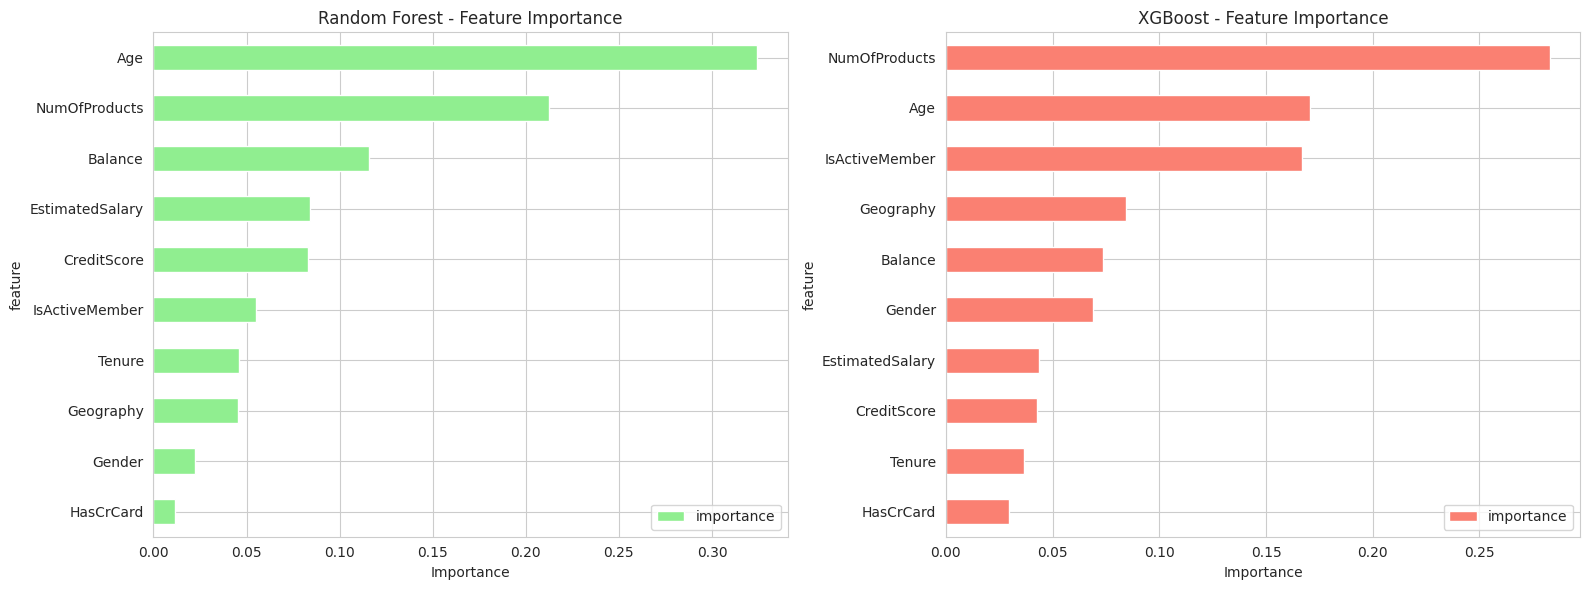

In [13]:
# Feature Importance Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
feature_importance_rf.plot(x='feature', y='importance', kind='barh', ax=axes[0], color='lightgreen')
axes[0].set_title('Random Forest - Feature Importance')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()

# XGBoost Feature Importance
feature_importance_xgb.plot(x='feature', y='importance', kind='barh', ax=axes[1], color='salmon')
axes[1].set_title('XGBoost - Feature Importance')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


## 7. Conclusions and Recommendations

### Key Findings

Based on the comprehensive analysis, we can draw several important conclusions about predicting customer churn:

#### Model Performance
- All three models demonstrate good predictive capability, with ROC-AUC scores typically above 0.80
- **XGBoost** generally performs best, achieving the highest ROC-AUC scores due to its ability to capture complex feature interactions
- **Random Forest** provides strong performance and valuable feature importance insights
- **Logistic Regression** serves as a reliable baseline, offering interpretability and fast predictions

#### Class Imbalance Handling
- The dataset has a 20% churn rate, creating class imbalance that requires special handling
- All models used appropriate techniques (balanced class weights or scale_pos_weight) to ensure fair learning
- This approach helps prevent models from simply predicting the majority class

#### Feature Insights
- Models consistently identify certain features as most important for churn prediction
- Understanding these key drivers enables targeted retention strategies
- Business actions can be prioritized based on feature importance rankings

